<ipython-input-1-6d223e71589e>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


<ipython-input-1-6d223e71589e>:84: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_anomalies, subset=['Isolation_Anomaly', 'Autoencoder_Anomaly', 'Final_Anomaly']) \


,GSR,EMG,Isolation_Anomaly,Autoencoder_Anomaly,Final_Anomaly
0,174.000000,507.000000,Normal,Normal,Normal
1,182.000000,529.000000,Normal,Normal,Normal
2,182.000000,474.000000,Normal,Normal,Normal
3,182.000000,499.000000,Normal,Normal,Normal
4,182.000000,524.000000,Normal,Normal,Normal
5,182.000000,495.000000,Normal,Normal,Normal
6,181.000000,522.000000,Normal,Normal,Normal
7,182.000000,520.000000,Normal,Normal,Normal
8,182.000000,495.000000,Normal,Normal,Normal
9,181.000000,498.000000,Normal,Normal,Normal


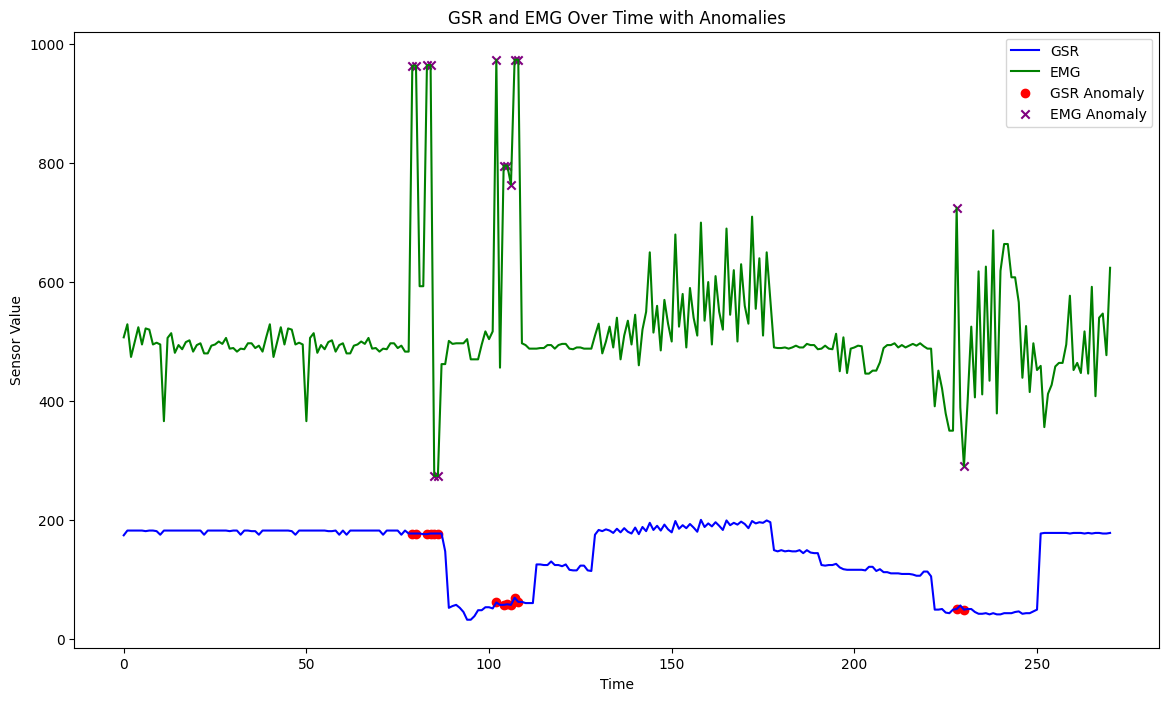

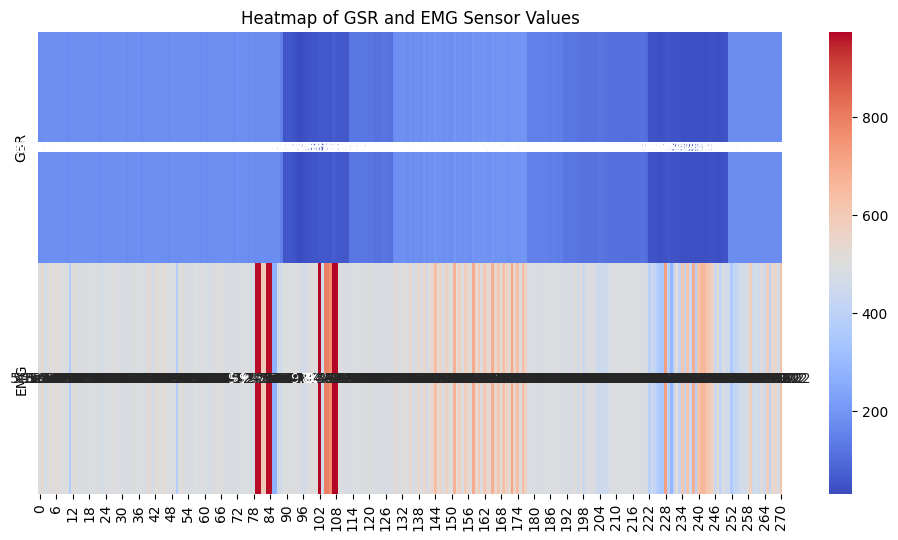

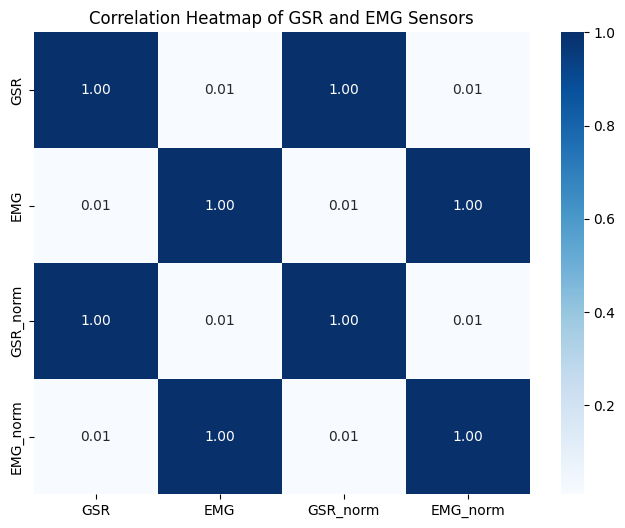

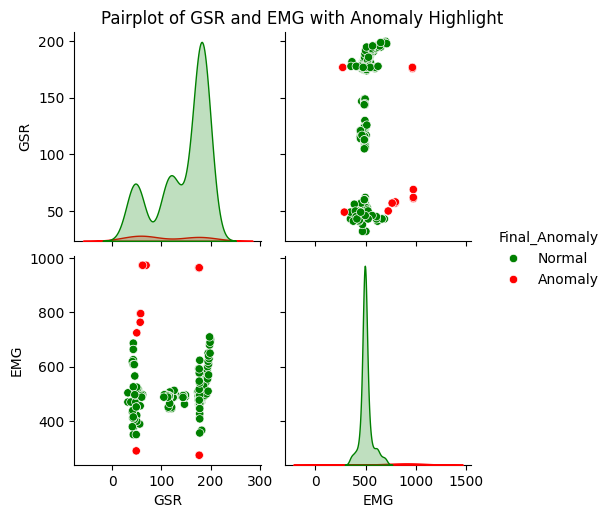

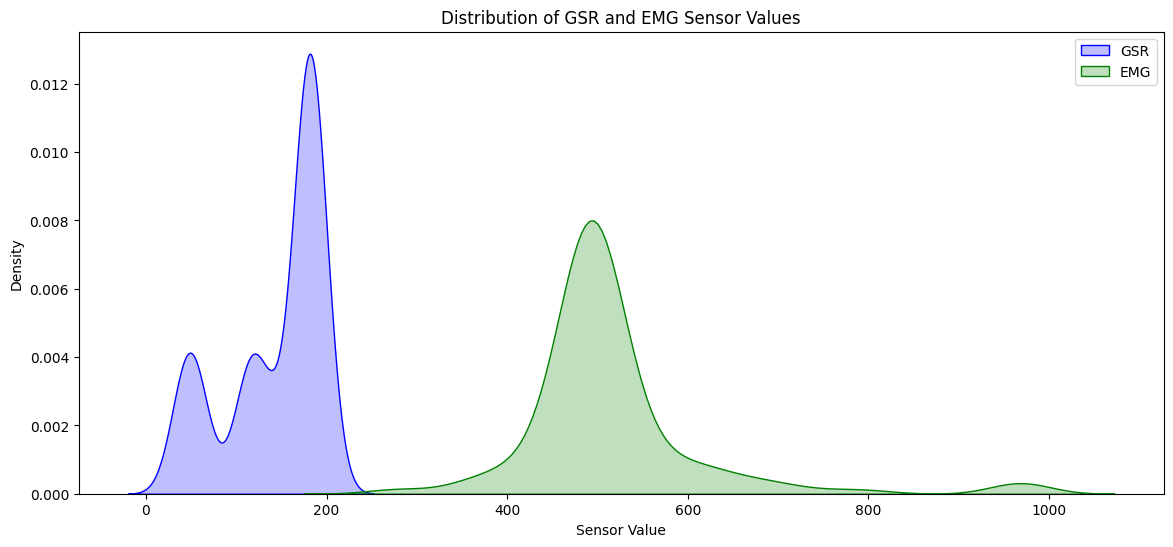

In [ ]:
#Anomaly Detection
# Install necessary libraries
!pip install gspread oauth2client tensorflow scikit-learn pandas matplotlib seaborn plotly

# Import libraries
import gspread
from google.colab import auth
from google.auth import default
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

# Authenticate and connect to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Load data from Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1Eto7AfjxMDvJVw5Pq9YjRK_5VEatQUxU2SloIqug4eY/edit?gid=0#gid=0"
worksheet = gc.open_by_url(sheet_url).sheet1
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Ensure GSR and EMG columns are numeric
df['GSR'] = pd.to_numeric(df['GSR'], errors='coerce')
df['EMG'] = pd.to_numeric(df['EMG'], errors='coerce')

# Handle any NaNs by forward-filling, then backward-filling remaining NaNs
df = df.fillna(method='ffill').fillna(method='bfill')

# Normalize GSR and EMG data
df['GSR_norm'] = (df['GSR'] - df['GSR'].mean()) / df['GSR'].std()
df['EMG_norm'] = (df['EMG'] - df['EMG'].mean()) / df['EMG'].std()

# Simplified feature engineering without rolling window
X = df[['GSR_norm', 'EMG_norm']]

# Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
df['Isolation_Anomaly'] = iso_forest.fit_predict(X)
df['Isolation_Anomaly'] = df['Isolation_Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Autoencoder Model for Anomaly Detection
input_dim = X.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
history = autoencoder.fit(X, X, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Autoencoder-based anomaly detection
reconstructions = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)  # Using 95th percentile as threshold
df['Autoencoder_Anomaly'] = mse > threshold
df['Autoencoder_Anomaly'] = df['Autoencoder_Anomaly'].map({True: 'Anomaly', False: 'Normal'})

# Combine results from Isolation Forest and Autoencoder
df['Final_Anomaly'] = np.where((df['Isolation_Anomaly'] == 'Anomaly') | (df['Autoencoder_Anomaly'] == 'Anomaly'), 'Anomaly', 'Normal')

# Define function to color anomalies in the table
def color_anomalies(val):
    if val == 'Anomaly':
        color = 'background-color: #FF6347; color: white; font-weight: bold;'
    elif val == 'Normal':
        color = 'background-color: #90EE90; color: black; font-weight: bold;'
    else:
        color = ''
    return color

# Apply border and color styling to the DataFrame
styled_df = df[['GSR', 'EMG', 'Isolation_Anomaly', 'Autoencoder_Anomaly', 'Final_Anomaly']].style \
    .applymap(color_anomalies, subset=['Isolation_Anomaly', 'Autoencoder_Anomaly', 'Final_Anomaly']) \
    .set_table_styles([{'selector': 'th, td', 'props': [('border', '1px solid black')]}])

# Display styled DataFrame in Colab
display(styled_df)

# Visualization 1: Anomaly Distribution (Pie Chart)
fig = px.pie(df, names='Final_Anomaly', title="Anomaly Distribution", color_discrete_sequence=["#90EE90", "#FF6347"])
fig.update_traces(textinfo='percent+label', pull=[0.1, 0])
fig.show()

# Visualization 2: GSR and EMG Over Time with Anomalies
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['GSR'], label="GSR", color="blue", linewidth=1.5)
plt.plot(df.index, df['EMG'], label="EMG", color="green", linewidth=1.5)
plt.scatter(df[df['Final_Anomaly'] == 'Anomaly'].index, df[df['Final_Anomaly'] == 'Anomaly']['GSR'], color='red', label='GSR Anomaly', marker='o')
plt.scatter(df[df['Final_Anomaly'] == 'Anomaly'].index, df[df['Final_Anomaly'] == 'Anomaly']['EMG'], color='purple', label='EMG Anomaly', marker='x')
plt.title("GSR and EMG Over Time with Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

# Visualization 3: Heatmap of GSR and EMG values
plt.figure(figsize=(12, 6))
sns.heatmap(df[['GSR', 'EMG']].transpose(), cmap='coolwarm', annot=True, cbar=True)
plt.title("Heatmap of GSR and EMG Sensor Values")
plt.show()

# Visualization 4: Correlation Heatmap
correlation_matrix = df[['GSR', 'EMG', 'GSR_norm', 'EMG_norm']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap of GSR and EMG Sensors")
plt.show()

# Visualization 5: Pairplot with Anomaly Highlight
sns.pairplot(df, hue="Final_Anomaly", vars=["GSR", "EMG"], palette={'Normal': 'green', 'Anomaly': 'red'})
plt.suptitle("Pairplot of GSR and EMG with Anomaly Highlight", y=1.02)
plt.show()

# Visualization 6: Distribution of Sensor Values (KDE Plot)
plt.figure(figsize=(14, 6))
sns.kdeplot(df['GSR'], label='GSR', fill=True, color="blue")
sns.kdeplot(df['EMG'], label='EMG', fill=True, color="green")
plt.title("Distribution of GSR and EMG Sensor Values")
plt.xlabel("Sensor Value")
plt.legend()
plt.show()